In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta

In [2]:
state_df = pd.read_csv('./us-states.csv')
state_df.tail(10)

,date,state,fips,cases,deaths
11279,2020-09-23,Tennessee,47,184068,2252
11280,2020-09-23,Texas,48,753551,15455
11281,2020-09-23,Utah,49,65948,444
11282,2020-09-23,Vermont,50,1722,58
11283,2020-09-23,Virgin Islands,78,1290,19
11284,2020-09-23,Virginia,51,142590,3089
11285,2020-09-23,Washington,53,88042,2175
11286,2020-09-23,West Virginia,54,14504,319
11287,2020-09-23,Wisconsin,55,112276,1269
11288,2020-09-23,Wyoming,56,5169,50


In [3]:
def weekofyear(date):
    """
    Convert date to week of year for plotting weekly data
    Intended use for pandas.dataframe.map
    Need to be done before dropping yeah from date
    """
    dt = datetime.strptime(date, '%Y-%m-%d')
    return int(dt.strftime('%U'))

#saturday
weekofyear('2020-08-22')


33

In [4]:
us_df = pd.read_csv('./us.csv')
us_df = us_df.sort_values('date')
us_df[us_df['date'] == '2020-03-09']

#slice to match up with Louisiana data for better comparison
us_df = us_df.iloc[48:,:]

#week of year
us_df['week'] = us_df['date'].map(weekofyear)  #maybe this will be used again later

#shorten date
us_df['date'] = us_df['date'].map(lambda x: x[5:])

us_df.tail()


,date,cases,deaths,week
242,09-19,6789360,199148,37
243,09-20,6825761,199361,38
244,09-21,6880635,199789,38
245,09-22,6917928,200731,38
246,09-23,6959409,201822,38


In [5]:
la_df = state_df[state_df['state'] == 'Louisiana']
la_df = la_df.sort_values(['date'], ascending=True)

#week of year
la_df['week'] = la_df['date'].map(weekofyear)  #maybe this will be used again later


#shorten date
la_df['date'] = la_df['date'].map(lambda x: x[5:])

la_df.head()

,date,state,fips,cases,deaths,week
431,03-09,Louisiana,22,1,0,10
468,03-10,Louisiana,22,6,0,10
509,03-11,Louisiana,22,13,0,10
555,03-12,Louisiana,22,14,0,10
604,03-13,Louisiana,22,36,0,10


In [6]:
def rollingavg(y, days = 7):
    y = np.array(y)
    
    output = np.zeros((y.shape[0] * days), dtype=np.float64).reshape((y.shape[0],days))
        
    for idx in range(7,y.shape[0]):
        output[idx] = y[idx-7:idx]
    
    return np.mean(output,axis=1)
    

In [7]:
la_df['cases_ravg'] = rollingavg(la_df['cases'])
la_df['deaths_ravg'] = rollingavg(la_df['deaths'])

us_df['cases_ravg'] = rollingavg(us_df['cases'])
us_df['deaths_ravg'] = rollingavg(us_df['deaths'])


In [8]:
us_df.tail(5)

,date,cases,deaths,week,cases_ravg,deaths_ravg
242,09-19,6789360,199148,37,6.618746e+06,195753.571429
243,09-20,6825761,199361,38,6.659414e+06,196552.857143
244,09-21,6880635,199789,38,6.700516e+06,197325.571429
245,09-22,6917928,200731,38,6.744193e+06,198095.142857
246,09-23,6959409,201822,38,6.787596e+06,198816.285714


In [9]:
la_df.head(5)

,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg
431,03-09,Louisiana,22,1,0,10,0.0,0.0
468,03-10,Louisiana,22,6,0,10,0.0,0.0
509,03-11,Louisiana,22,13,0,10,0.0,0.0
555,03-12,Louisiana,22,14,0,10,0.0,0.0
604,03-13,Louisiana,22,36,0,10,0.0,0.0


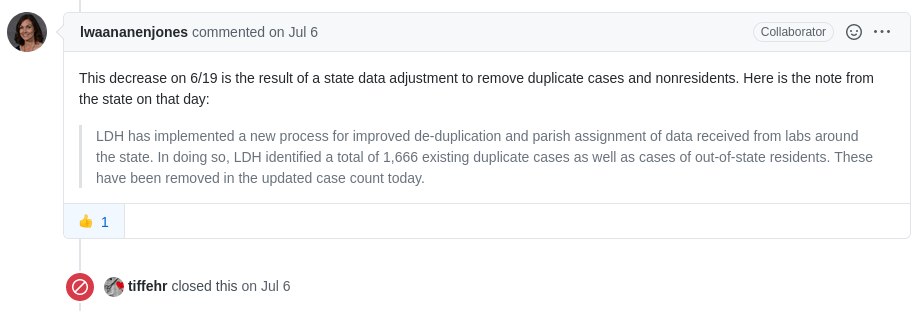

There was an issue with one of the days in louisiana which caused a negative result in the newcases for 6/19

https://github.com/nytimes/covid-19-data/issues/377

In [10]:
la_df.index = np.arange(la_df.shape[0])
us_df.index = np.arange(us_df.shape[0])

ticks = 10

la_items_pertick = la_df.shape[0] / ticks
la_ticks = np.append(np.arange(0,la_df.shape[0], la_items_pertick), [la_df.shape[0]-1])
la_items_pertick += 1

us_items_pertick = us_df.shape[0] / ticks
us_ticks = np.append(np.arange(0,us_df.shape[0], us_items_pertick),[us_df.shape[0]-1])
us_items_pertick += 1

us_df.iloc[us_ticks,0]


0      03-09
19     03-28
39     04-17
59     05-07
79     05-27
99     06-16
119    07-06
139    07-26
159    08-15
179    09-04
198    09-23
Name: date, dtype: object

In [11]:
def newstats(df):
    """
        Changes daily totals to new cases and new deaths and adds them to dateframe
    """
    #changing daily totals to new cases
    newcases = np.zeros(df.shape[0], dtype=np.int32)
    newdeaths = np.zeros(df.shape[0], dtype=np.int32)
    deathscolumn = df.columns.get_loc('deaths')
    casescolumn = df.columns.get_loc('cases')

    newcases[0] = df.iloc[0,casescolumn]
    newdeaths[0] = df.iloc[0,deathscolumn]


    for idx in df.index[1:]:
        newcases[idx] = df.iloc[idx,casescolumn] - df.iloc[idx-1,casescolumn]
        newdeaths[idx] = df.iloc[idx,deathscolumn] - df.iloc[idx-1,deathscolumn]

    df['NewCases'] = newcases
    df['NewDeaths'] = newdeaths
    df['NewCasesRollAvg'] = rollingavg(newcases)
    df['NewDeathsRollAvg'] = rollingavg(newdeaths)
  

In [12]:
newstats(us_df)
us_df.tail(5)

,date,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg
194,09-19,6789360,199148,37,6.618746e+06,195753.571429,41844,672,40283.142857,803.000000
195,09-20,6825761,199361,38,6.659414e+06,196552.857143,36401,213,40668.142857,799.285714
196,09-21,6880635,199789,38,6.700516e+06,197325.571429,54874,428,41101.285714,772.714286
197,09-22,6917928,200731,38,6.744193e+06,198095.142857,37293,942,43677.714286,769.571429
198,09-23,6959409,201822,38,6.787596e+06,198816.285714,41481,1091,43402.285714,721.142857


In [13]:
newstats(la_df)
la_df.tail(5)

,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg
194,09-19,Louisiana,22,161322,5340,37,159309.142857,5273.142857,0,0,601.857143,19.714286
195,09-20,Louisiana,22,162258,5366,38,159911.000000,5292.857143,936,26,601.857143,19.714286
196,09-21,Louisiana,22,162501,5375,38,160463.571429,5311.571429,243,9,552.571429,18.714286
197,09-22,Louisiana,22,163253,5386,38,160980.571429,5329.142857,752,11,517.000000,17.571429
198,09-23,Louisiana,22,163869,5407,38,161552.000000,5344.571429,616,21,571.428571,15.428571


In [14]:
#for comparison
uspop2010percap = 308745538 / 100000
lapop2010percap = 4533372 / 100000

la_df['NewCasesPerCapita'] = la_df['NewCases'] / lapop2010percap
la_df['NewDeathsPerCapita'] = la_df['NewDeaths'] / lapop2010percap

us_df['NewCasesPerCapita'] = us_df['NewCases'] / uspop2010percap
us_df['NewDeathsPerCapita'] = us_df['NewDeaths'] / uspop2010percap

la_df['NewCasesPerCapita_ravg'] = rollingavg(la_df['NewCasesPerCapita'])
la_df['NewDeathsPerCapita_ravg'] = rollingavg(la_df['NewDeathsPerCapita'])

us_df['NewCasesPerCapita_ravg'] = rollingavg(us_df['NewCasesPerCapita'])
us_df['NewDeathsPerCapita_ravg'] = rollingavg(us_df['NewDeathsPerCapita'])


la_df.tail(5)

,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
194,09-19,Louisiana,22,161322,5340,37,159309.142857,5273.142857,0,0,601.857143,19.714286,0.000000,0.000000,13.276147,0.434870
195,09-20,Louisiana,22,162258,5366,38,159911.000000,5292.857143,936,26,601.857143,19.714286,20.646883,0.573525,13.276147,0.434870
196,09-21,Louisiana,22,162501,5375,38,160463.571429,5311.571429,243,9,552.571429,18.714286,5.360248,0.198528,12.188972,0.412812
197,09-22,Louisiana,22,163253,5386,38,160980.571429,5329.142857,752,11,517.000000,17.571429,16.588094,0.242645,11.404314,0.387602
198,09-23,Louisiana,22,163869,5407,38,161552.000000,5344.571429,616,21,571.428571,15.428571,13.588119,0.463231,12.604935,0.340333


In [15]:
%matplotlib inline

In [16]:
def drawindexofCDCdataloss(df,ax, color="magenta", label="CDC Loses Ctrl"):
    """
        Draws a line at the date where CDC took control of data
        
        Reference:  https://www.nytimes.com/2020/07/14/us/politics/trump-cdc-coronavirus.html
    """
    JudgementDate = '04-05'
    ax.axvline(df[df['date']==JudgementDate].index.values[0],ymin=0, ymax=1,label=label, color=color,zorder=-100)
    

In [17]:
def getyTicks(df, columns, yticks=8):
    """
        Gets yTicks and returns labels
    """
    dfmax = np.max(df[columns])
    items_per_tick = dfmax / yticks
    out_yticks = np.arange(0,dfmax,items_per_tick)
    #axs[0].set_yticks(la_yticks)
    out_ticklabels = []
    for i in out_yticks:
        if i > 1000000:
            out_ticklabels.append("{0:,.3g}M".format(i/1000000.))
        elif i > 10000:
            out_ticklabels.append("{0:,.3g}K".format(i/1000.0))
        else:
            out_ticklabels.append("{0:,.0f}".format(i))

    return (out_yticks, out_ticklabels)

In [18]:
#This is to mark the dataset problem mentioned above

def LACFline(df,ax):
    """
        Adds a line for data adjustment to LA data on 6/19 mentioned above.  nytimes issues 377
    """
    
    idx = df[df['date']=='06-19'].index.values[0]
    line = ax.axvline(idx,ymin=0,ymax=1,color='r',label="LA Data Adjust", zorder=-100)
    
    return line


In [19]:
def holidays(df,ax):
    """
        Adds lines for major holiday
        
    """
    holidays_list = [
        ('03-25','Memorial Day'),
        ('07-04', '4th of July'),
        ('04-12','Easter'),
        ('09-07','Labor Day')
    ]
    
    label = "Holiday"
    for h in holidays_list:
        line = ax.axvline(df[df['date']==h[0]].index.values[0],ymin=0,ymax=1,color='pink',label=label, zorder=-100)
        label = None
    
    return line
    

Text(0.5, 0.98, 'New Daily Cases/Deaths Covid-19 La vs US')

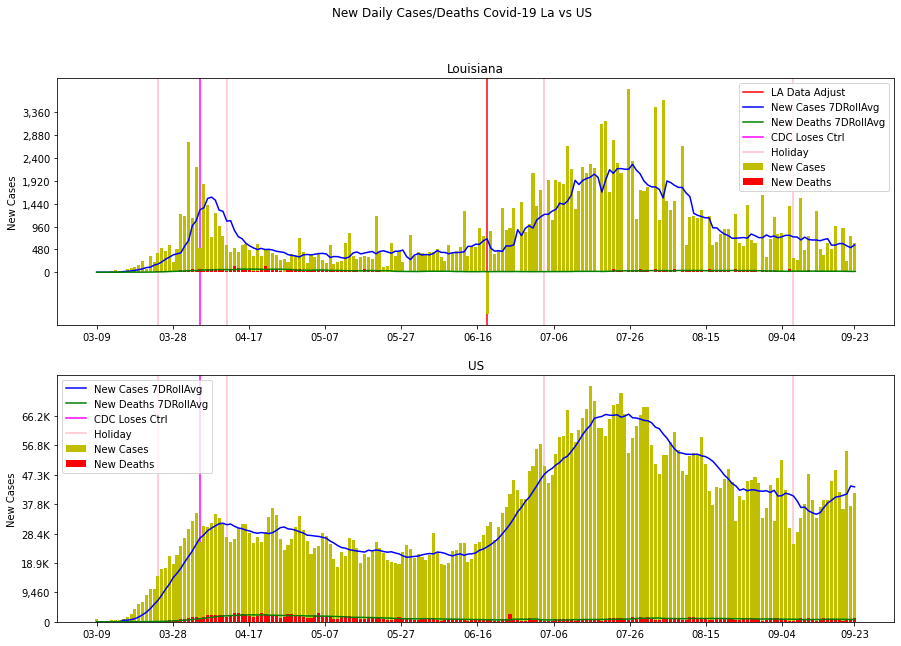

In [20]:


fig, axs = plt.subplots(2, figsize=(15,10))

def plotme(df, ax,xticks):
    


    ax.bar(df.index,df['NewCases'], color='y', label='New Cases')
    ax.bar(df.index,df['NewDeaths'], color='r', label='New Deaths')
    ax.plot(df.index,df['NewCasesRollAvg'], color = 'b',label='New Cases 7DRollAvg')
    ax.plot(df.index,df['NewDeathsRollAvg'], color = 'g', label='New Deaths 7DRollAvg')
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    

axs[0].title.set_text('Louisiana')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)

axs[1].title.set_text('US')
plotme(us_df,axs[1],us_ticks)

fig.suptitle("New Daily Cases/Deaths Covid-19 La vs US")






Text(0.5, 0.98, 'Covid-19 La vs US Totals')

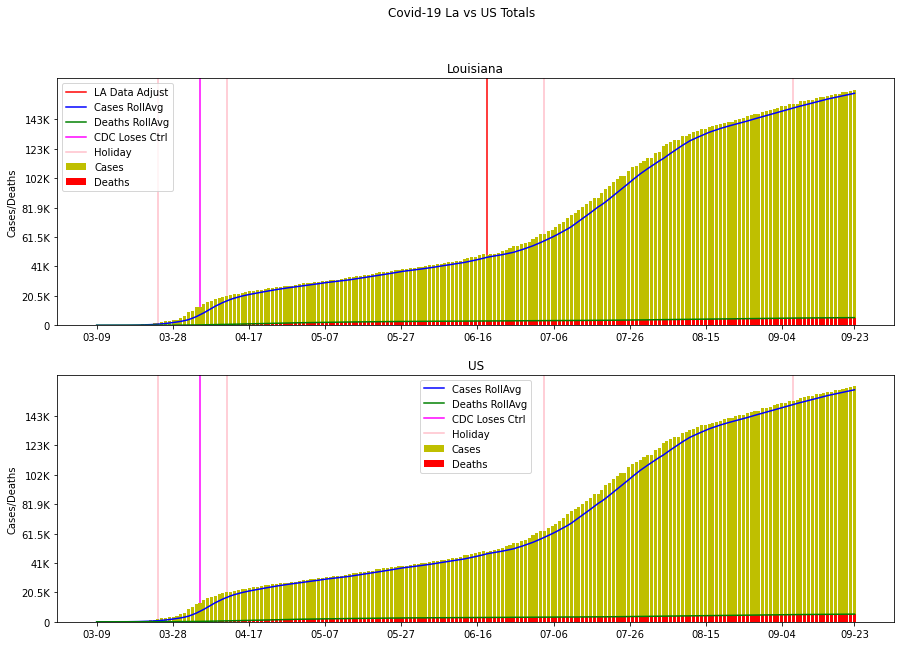

In [21]:
fig, axs = plt.subplots(2, figsize=(15,10))

def plotme(df,ax, xticks):
    ax.bar(df.index,la_df['cases'], color='y', label='Cases')
    ax.bar(df.index,la_df['deaths'], color='r', label='Deaths')
    ax.plot(df.index,la_df['cases_ravg'], color = 'b',label='Cases RollAvg')
    ax.plot(df.index,la_df['deaths_ravg'], color = 'g', label='Deaths RollAvg')
    ax.set_xticks(xticks)
    ax.set_xticklabels(la_df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    

    yticks,yticklabels = getyTicks(la_df,'cases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Cases/Deaths")

axs[0].title.set_text('Louisiana')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)    

axs[1].title.set_text('US')
plotme(us_df,axs[1],us_ticks)

fig.suptitle("Covid-19 La vs US Totals")

#fig.tight_layout()




Text(0.5, 0.98, 'Covid-19 La vs US New Deaths Daily')

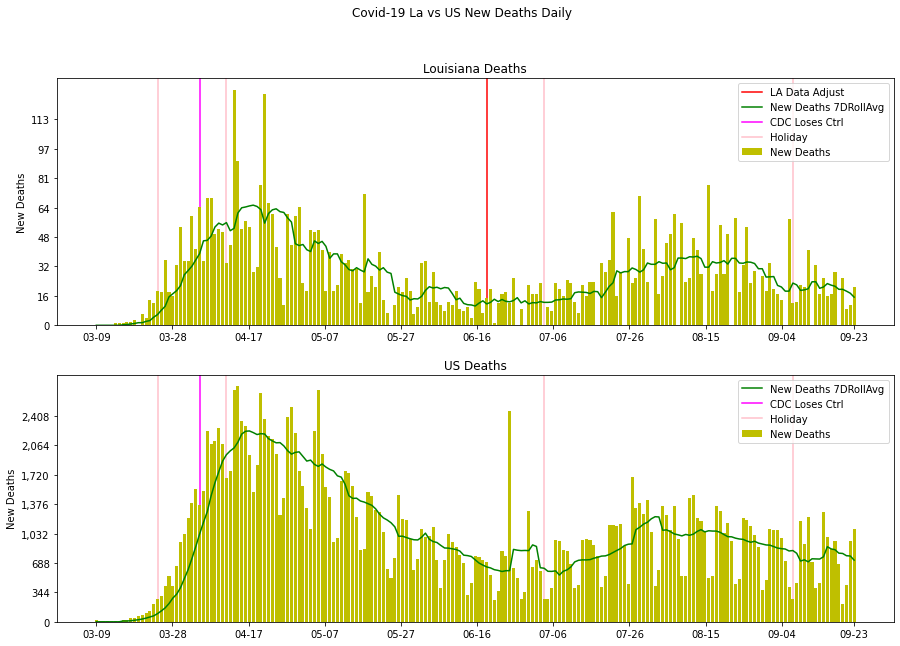

In [22]:
fig, axs = plt.subplots(2, figsize=(15,10))

def plotme(df,ax,xticks):

    ax.bar(df.index,df['NewDeaths'], color = 'y', label="New Deaths")
    ax.plot(df.index,df['NewDeathsRollAvg'], color='g', label="New Deaths 7DRollAvg")
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()

    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")

axs[0].title.set_text('Louisiana Deaths')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)


axs[1].title.set_text('US Deaths')
plotme(us_df,axs[1],us_ticks)

fig.suptitle("Covid-19 La vs US New Deaths Daily")



In [23]:
la_df_weekly = la_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly = us_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly.tail()

,NewCases,NewDeaths
week,,
34,294003,6363
35,287109,5799
36,242113,5144
37,284677,5595
38,170049,2674


Text(0.5, 0.98, 'Covid-19 La vs US New Cases/Deaths per capita 7 day rolling avg ')

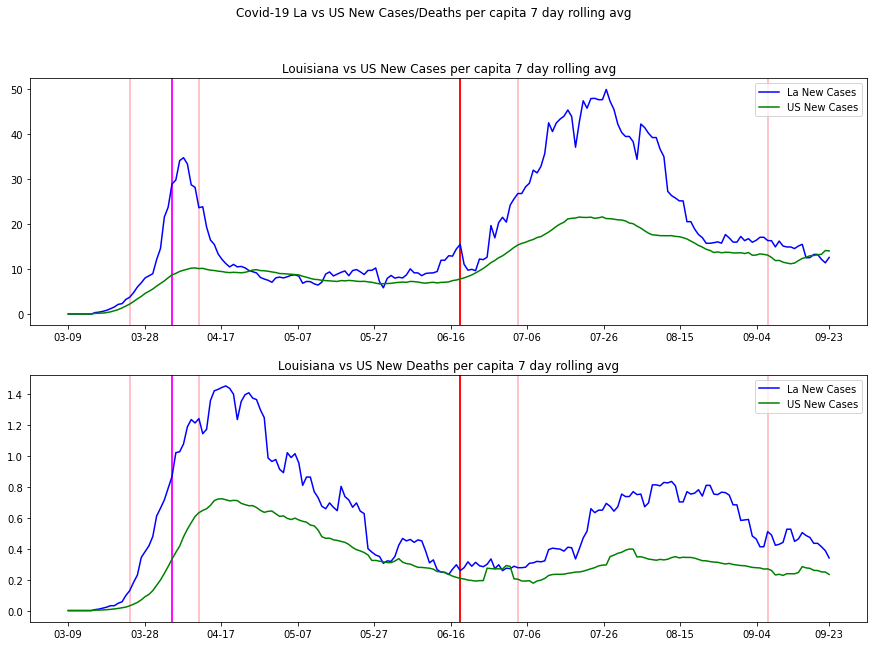

In [24]:
#problem with the legend need to work on this

def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    #yticks,yticklabels = getyTicks(df,column)
    #ax.set_yticks(yticks)        
    #ax.set_yticklabels(yticklabels)
    #ax.set_ylabel(label,color=color)
    #ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(2, figsize=(15,10))

for col,ax in zip(['NewCasesPerCapita_ravg','NewDeathsPerCapita_ravg'],axs):
    
    
    line1 = plotme(la_df,ax,la_ticks, col,"La New Cases", color='b')
    
    line2 = plotme(us_df,ax,us_ticks, col,'US New Cases', color='g')
    
    ax.legend(handles=[line1[0][0],line2[0][0]])
    
    
    

axs[0].title.set_text('Louisiana vs US New Cases per capita 7 day rolling avg')
axs[1].title.set_text('Louisiana vs US New Deaths per capita 7 day rolling avg')


fig.suptitle("Covid-19 La vs US New Cases/Deaths per capita 7 day rolling avg ")



Text(0.5, 0.98, 'Covid-19 La vs US New Cases/Deaths 7 day rolling avg Compared (separatly scaled)')

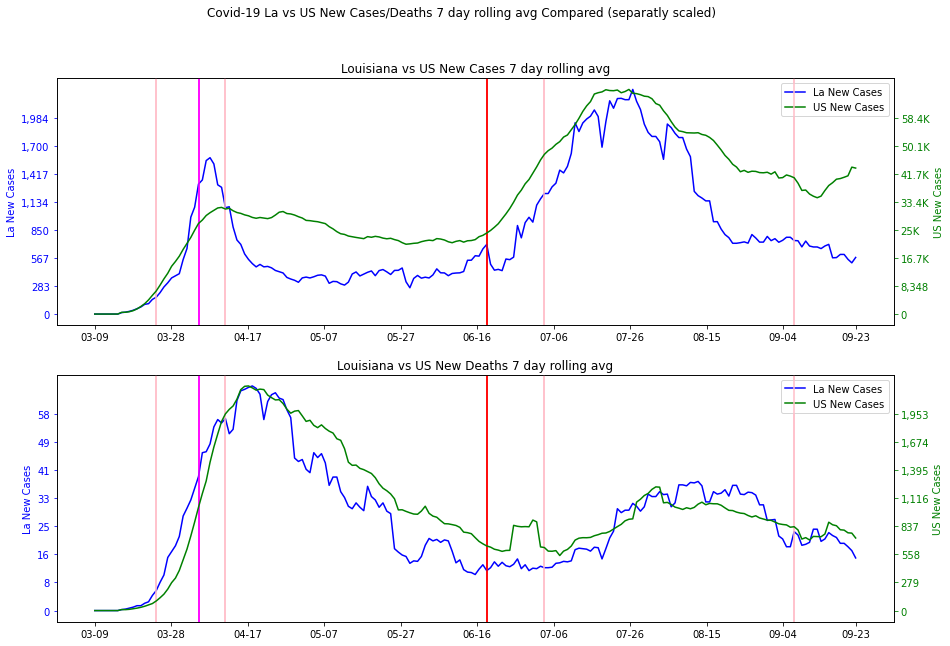

In [25]:
#problem with the legend need to work on this

def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(2, figsize=(15,10))

for col,ax in zip(['NewCasesRollAvg','NewDeathsRollAvg'],axs):
    
    
    line1 = plotme(la_df,ax,la_ticks, col,"La New Cases", color='b')
    
    
    axsY2 = ax.twinx()

    line2 = plotme(us_df,axsY2,us_ticks, col,'US New Cases', color='g')
    
    ax.legend(handles=[line1[0][0],line2[0][0]])
    
    
    

axs[0].title.set_text('Louisiana vs US New Cases 7 day rolling avg')
axs[1].title.set_text('Louisiana vs US New Deaths 7 day rolling avg')


fig.suptitle("Covid-19 La vs US New Cases/Deaths 7 day rolling avg Compared (separatly scaled)")



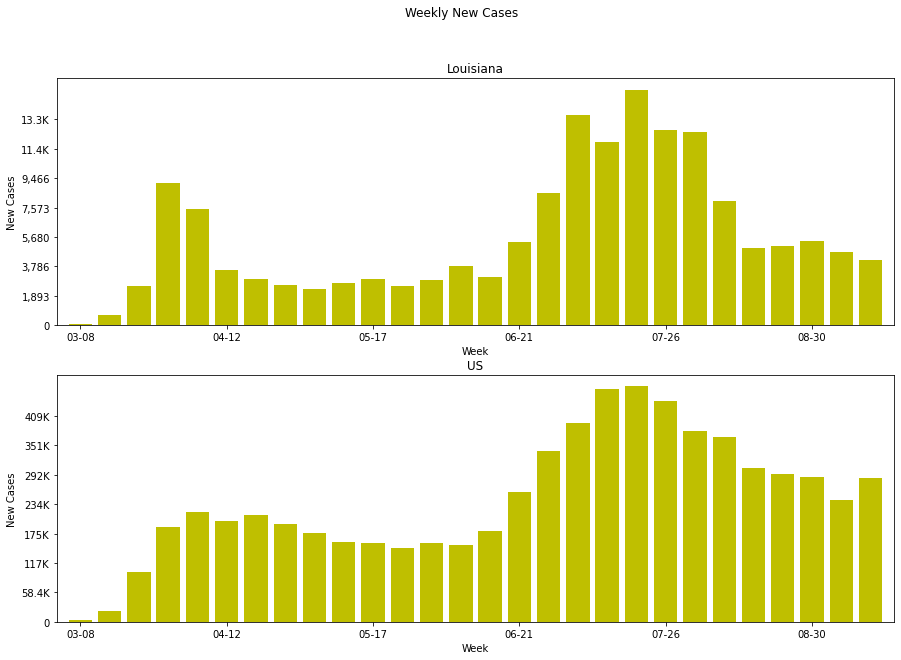

In [26]:
def plotme(df,ax, title = "Graphs", color = 'y'):
    ax.bar(df.index[:-1],df['NewCases'][:-1], color=color)
    ax.set_title(title)
    ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
    
    
fig, axs = plt.subplots(2, figsize=(15,10))
fig.suptitle("Weekly New Cases")

plotme(la_df_weekly,axs[0], title="Louisiana")

plotme(us_df_weekly,axs[1], title="US")



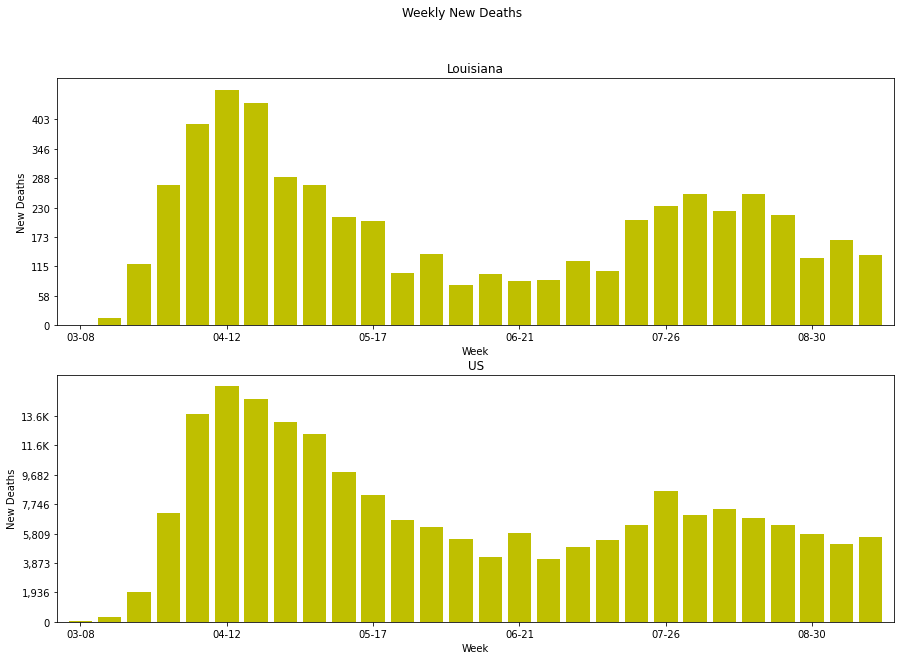

In [27]:
def plotme(df,ax, title = "Graphs", color = 'y'):
    ax.bar(df.index[:-1],df['NewDeaths'][:-1], color=color)
    ax.set_title(title)
    ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
    
    
fig, axs = plt.subplots(2, figsize=(15,10))
fig.suptitle("Weekly New Deaths")

plotme(la_df_weekly,axs[0], title="Louisiana")

plotme(us_df_weekly,axs[1], title="US")